In [ ]:
!apt-get update
!apt-get install python3-pip -y


Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [ ]:
!pip --version


pip 24.1.2 from /usr/local/lib/python3.12/dist-packages/pip (python 3.12)


In [ ]:
# Install PyTorch Geometric (minimal install)
!pip install torch-geometric

# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import EllipticBitcoinDataset
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split

# Set device
DEVICE = torch.device('cpu')  # Use 'cuda' if GPU is available
print(f'Using device: {DEVICE}')

# Load the dataset
dataset = EllipticBitcoinDataset(root='./dataset')
data = dataset[0].to(DEVICE)
print(data)

# Ensure edge_index is long type
data.edge_index = data.edge_index.to(torch.long)

# Prepare labels mask (exclude unlabeled nodes)
mask = data.y != -1
labels = data.y.clone()


Using device: cpu
Data(x=[203769, 165], edge_index=[2, 234355], y=[203769], train_mask=[203769], test_mask=[203769])


In [ ]:
# Extract indices of labeled nodes
mask_idx = mask.nonzero(as_tuple=True)[0]

# Stratified train/test split
train_idx, test_idx = train_test_split(
    mask_idx.cpu(),
    test_size=0.3,
    stratify=labels[mask].cpu(),
    random_state=42
)

# Split test into validation and test
val_idx, test_idx = train_test_split(
    test_idx,
    test_size=0.5,
    stratify=labels[test_idx].cpu(),
    random_state=42
)

# Convert indices to torch tensors on DEVICE
train_idx = torch.tensor(train_idx, dtype=torch.long, device=DEVICE)
val_idx = torch.tensor(val_idx, dtype=torch.long, device=DEVICE)
test_idx = torch.tensor(test_idx, dtype=torch.long, device=DEVICE)

print(f"Train size: {train_idx.size(0)}, Val size: {val_idx.size(0)}, Test size: {test_idx.size(0)}")


Train size: 142638, Val size: 30565, Test size: 30566


/tmp/ipython-input-3896827760.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_idx = torch.tensor(train_idx, dtype=torch.long, device=DEVICE)
/tmp/ipython-input-3896827760.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_idx = torch.tensor(val_idx, dtype=torch.long, device=DEVICE)
/tmp/ipython-input-3896827760.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_idx = torch.tensor(test_idx, dtype=torch.long, device=DEVICE)


In [ ]:
# Extract training labels
train_labels = labels[train_idx]

# Count number of nodes per class
class_counts = torch.bincount(train_labels)

# Handle case where some classes might be missing in batch
if class_counts.numel() < 2:
    tmp = torch.zeros(2, dtype=class_counts.dtype, device=class_counts.device)
    tmp[:class_counts.numel()] = class_counts
    class_counts = tmp

# Compute inverse frequency weights and normalize
class_weights = 1.0 / class_counts.float()
class_weights = (class_weights / class_weights.sum()) * len(class_counts)
class_weights = class_weights.to(DEVICE)

print("Class counts:", class_counts.cpu().numpy())
print("Class weights:", class_weights.cpu().numpy())

# Define Cross-Entropy Loss with class weights
ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)


Class counts: [ 29413   3182 110043]
Class weights: [0.28541952 2.6382918  0.07628876]


In [ ]:
from torch_geometric.nn import GCNConv

class BWGNNEncoder(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.3):
        super().__init__()
        # Parallel GCN layers for band-pass (simulating Beta wavelets)
        self.gcn_low = GCNConv(in_dim, hid_dim)    # Low-pass
        self.gcn_mid = GCNConv(in_dim, hid_dim)    # Mid-band
        self.gcn_high = GCNConv(in_dim, hid_dim)   # High-pass

        self.fc_out = nn.Linear(hid_dim * 3, out_dim)  # Combine all branches
        self.dropout = dropout

    def forward(self, x, edge_index):
        # Each branch
        x_low = F.relu(self.gcn_low(x, edge_index))
        x_mid = F.relu(self.gcn_mid(x, edge_index))
        x_high = F.relu(self.gcn_high(x, edge_index))

        # Dropout
        x_low = F.dropout(x_low, p=self.dropout, training=self.training)
        x_mid = F.dropout(x_mid, p=self.dropout, training=self.training)
        x_high = F.dropout(x_high, p=self.dropout, training=self.training)

        # Concatenate features from all branches
        x_cat = torch.cat([x_low, x_mid, x_high], dim=1)
        z = self.fc_out(x_cat)  # final embedding
        return z

class BWGNNClassifier(nn.Module):
    def __init__(self, encoder, num_classes, dropout=0.3):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(encoder.fc_out.out_features, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        logits = self.classifier(F.dropout(z, p=self.dropout, training=self.training))
        return logits, z


In [ ]:
def recon_loss_from_z(z, edge_index):
    """
    Simple unsupervised reconstruction loss.
    Measures similarity of connected nodes in embedding space.
    """
    row, col = edge_index
    # Dot product of embeddings for each edge
    pos_scores = (z[row] * z[col]).sum(dim=1)
    # Apply sigmoid + log for binary cross-entropy style loss
    loss = -torch.log(torch.sigmoid(pos_scores) + 1e-8).mean()
    return loss


In [ ]:
# Hyperparameters
in_dim = data.x.size(1)
hid_dim = 128
emb_dim = 64
num_classes = 3       # same as SAGE
lr = 0.01
weight_decay = 5e-4
dropout = 0.3
epochs = 11
lambda_recon = 0.1   # weight for reconstruction loss

# Instantiate encoder and classifier
encoder = BWGNNEncoder(in_dim, hid_dim, emb_dim, dropout=dropout).to(DEVICE)
model_bwgnn = BWGNNClassifier(encoder, num_classes, dropout=dropout).to(DEVICE)

# Optimizer
optimizer = torch.optim.Adam(model_bwgnn.parameters(), lr=lr, weight_decay=weight_decay)

print("BWGNN model instantiated and optimizer ready.")


BWGNN model instantiated and optimizer ready.


In [ ]:
# Store metrics if needed
metrics_data = {}

for epoch in range(1, epochs + 1):
    model_bwgnn.train()
    optimizer.zero_grad()

    # Forward pass
    logits, z_all = model_bwgnn(data.x, data.edge_index)

    # Cross-entropy loss on training nodes
    loss_ce = ce_loss_fn(logits[train_idx], labels[train_idx])

    # Optional reconstruction loss
    if lambda_recon > 0:
        rloss = recon_loss_from_z(z_all, data.edge_index)
    else:
        rloss = torch.tensor(0.0, device=DEVICE)

    # Total loss
    loss = loss_ce + lambda_recon * rloss
    loss.backward()
    optimizer.step()

    # Validation metrics every 5 epochs
    if epoch % 5 == 0 or epoch == 1:
        model_bwgnn.eval()
        with torch.no_grad():
            logits_val, _ = model_bwgnn(data.x, data.edge_index)
            preds_val = logits_val[val_idx].argmax(dim=1).cpu()
            true_val = labels[val_idx].cpu()
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | CE: {loss_ce.item():.4f} | Recon: {rloss.item():.4f}")
            from sklearn.metrics import classification_report
            print("Validation metrics:")
            print(classification_report(
              true_val,
              preds_val,
              labels=[0,1,2],  # list all possible class labels
              target_names=['licit(0)','illicit(1)','unknown(2)'],
              zero_division=0
            ))



Epoch 001 | Loss: 1.1610 | CE: 1.1536 | Recon: 0.0741
Validation metrics:
              precision    recall  f1-score   support

    licit(0)       0.22      0.98      0.36      6303
  illicit(1)       0.00      0.00      0.00       681
  unknown(2)       0.93      0.10      0.18     23581

    accuracy                           0.28     30565
   macro avg       0.38      0.36      0.18     30565
weighted avg       0.76      0.28      0.21     30565

Epoch 005 | Loss: 0.9940 | CE: 0.9358 | Recon: 0.5819
Validation metrics:
              precision    recall  f1-score   support

    licit(0)       0.56      0.62      0.59      6303
  illicit(1)       0.03      0.95      0.06       681
  unknown(2)       0.96      0.14      0.25     23581

    accuracy                           0.26     30565
   macro avg       0.52      0.57      0.30     30565
weighted avg       0.86      0.26      0.31     30565

Epoch 010 | Loss: 0.8609 | CE: 0.8608 | Recon: 0.0005
Validation metrics:
              pr

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import torch.nn.functional as F

# Evaluation function for BWGNN (similar to SAGE)
def evaluate_model(model, data, test_idx, labels, name, metrics_store):
    model.eval()
    with torch.no_grad():
        logits, _ = model(data.x, data.edge_index)
        preds = logits.argmax(dim=1)[test_idx].cpu()
        y_true = labels[test_idx].cpu()

    precision = precision_score(y_true, preds, average='macro', zero_division=0)
    recall = recall_score(y_true, preds, average='macro', zero_division=0)
    f1 = f1_score(y_true, preds, average='macro', zero_division=0)
    acc = accuracy_score(y_true, preds)
    report = classification_report(y_true, preds, output_dict=True, zero_division=0)

    metrics_store[name] = {
        "precision": round(precision, 4),
        "recall": round(recall, 4),
        "f1": round(f1, 4),
        "accuracy": round(acc, 4),
        "per_class_report": report
    }

    print(f"✅ {name} Model Results:")
    print(f"  Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Accuracy: {acc:.4f}\n")
    return preds

# Known nodes mask: classes 0 and 1
known_mask = (labels == 0) | (labels == 1)
known_idx = known_mask.nonzero(as_tuple=True)[0]
unknown_idx = (labels == 2).nonzero(as_tuple=True)[0]

# Train/Val split for known nodes
train_idx, val_idx = train_test_split(
    known_idx.cpu().numpy(),
    test_size=0.2,
    stratify=labels[known_idx].cpu().numpy(),
    random_state=42
)
train_idx = torch.tensor(train_idx, dtype=torch.long, device=DEVICE)
val_idx = torch.tensor(val_idx, dtype=torch.long, device=DEVICE)
test_unknown_idx = unknown_idx.to(DEVICE)

# Evaluate BWGNN on known test nodes
evaluate_model(model_bwgnn, data, val_idx, labels, "BWGNN", metrics_data)

# Predict probabilities for unknown nodes (class 2)
model_bwgnn.eval()
with torch.no_grad():
    logits_all, _ = model_bwgnn(data.x, data.edge_index)
    probs = F.softmax(logits_all, dim=1)
    # For unknown nodes, probability of illicit class (1)
    illicit_probs_unknown = probs[test_unknown_idx, 1].cpu()
    # Rank top-K suspicious nodes
    topk = 100
    if illicit_probs_unknown.numel() > topk:
        topk_vals, topk_idx_local = torch.topk(illicit_probs_unknown, topk)
    else:
        topk_vals = illicit_probs_unknown
        topk_idx_local = torch.arange(illicit_probs_unknown.size(0))
    topk_node_indices = test_unknown_idx[topk_idx_local]
    print(f"Top-{topk} suspicious unknown nodes (example indices): {topk_node_indices[:20].cpu().numpy()}")


✅ BWGNN Model Results:
  Precision: 0.5607 | Recall: 0.3311 | F1: 0.4106 | Accuracy: 0.6573

Top-100 suspicious unknown nodes (example indices): [126460 116693 114916 126197 151074 150904 150603 151256 151373 151366
 151323 149122  64509  46045  44378  48619 192696 125536  58142 192182]


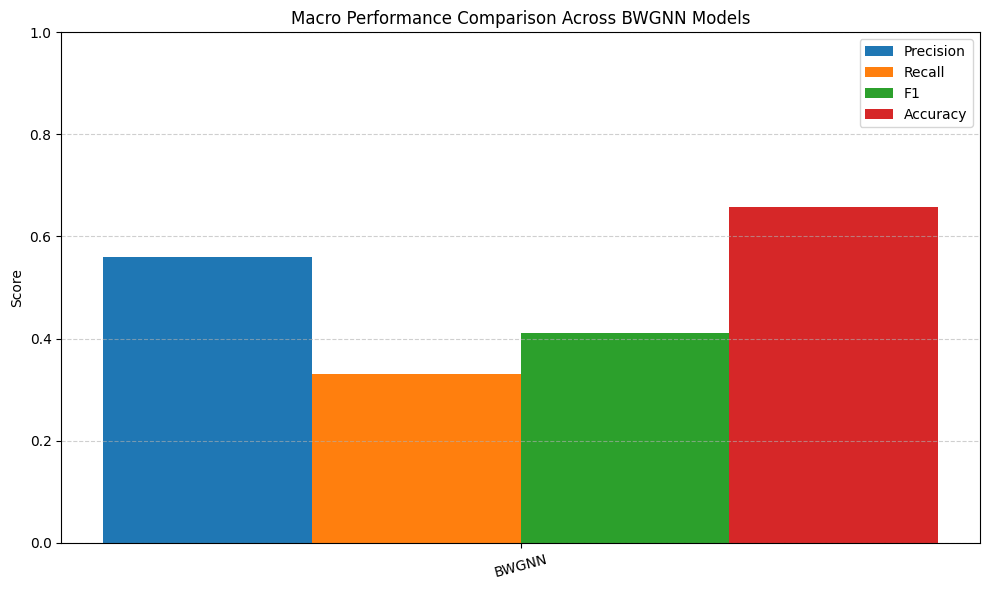

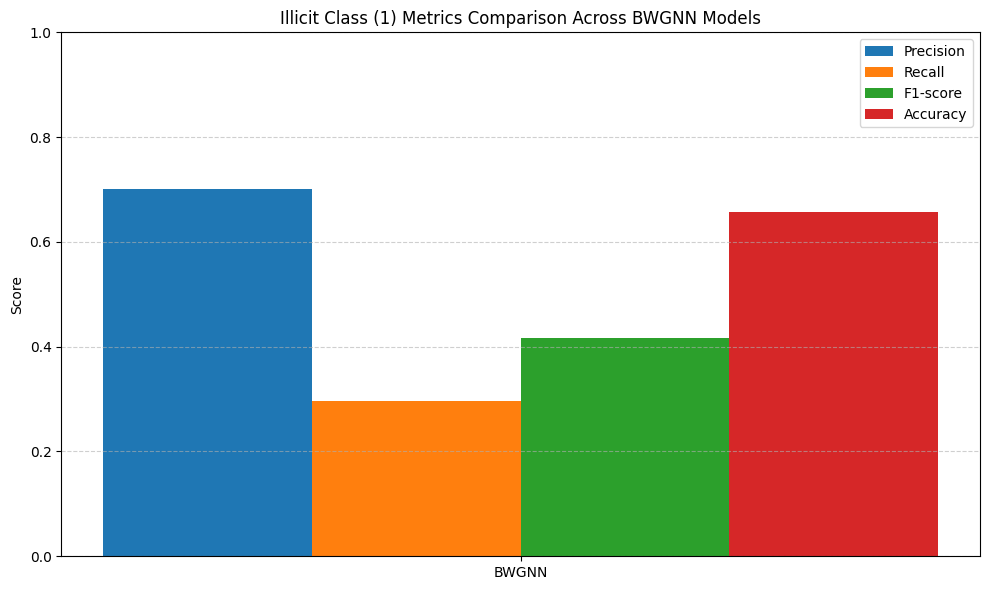

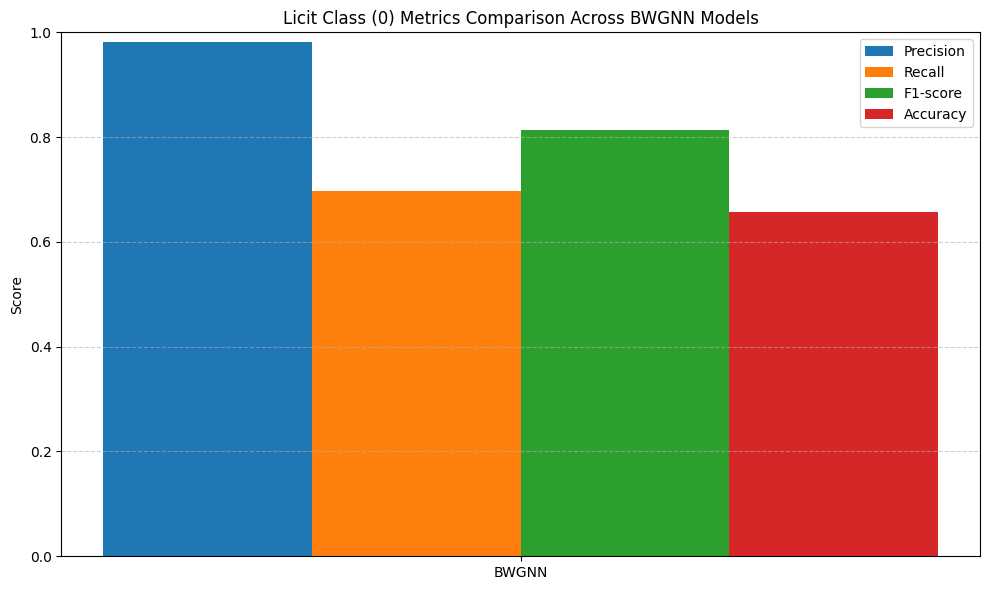

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Macro metrics
macro_metrics = ["precision", "recall", "f1", "accuracy"]
models = list(metrics_data.keys())

# Grouped bar plot for macro metrics
x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(10,6))
for i, metric in enumerate(macro_metrics):
    values = [metrics_data[m][metric] for m in models]
    plt.bar(x + i*width - width*1.5, values, width, label=metric.capitalize())

plt.xticks(x, models, rotation=15)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Macro Performance Comparison Across BWGNN Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Metrics per class (0 and 1)
metrics_to_plot = ["precision", "recall", "f1-score", "accuracy"]
values_dict = {metric: [] for metric in metrics_to_plot}

for model in models:
    report = metrics_data[model]["per_class_report"]
    # Class 1 metrics
    for metric in ["precision", "recall", "f1-score"]:
        values_dict[metric].append(report.get("1", {}).get(metric, 0.0))
    # Overall accuracy
    values_dict["accuracy"].append(metrics_data[model].get("accuracy", 0.0))

# Plot Illicit class (1)
x = np.arange(len(models))
bar_width = 0.2
plt.figure(figsize=(10,6))
for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i*bar_width - bar_width*1.5, values_dict[metric], width=bar_width, label=metric.capitalize())

plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Illicit Class (1) Metrics Comparison Across BWGNN Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot Licit class (0)
values_dict = {metric: [] for metric in metrics_to_plot}
for model in models:
    report = metrics_data[model]["per_class_report"]
    for metric in ["precision", "recall", "f1-score"]:
        values_dict[metric].append(report.get("0", {}).get(metric, 0.0))
    values_dict["accuracy"].append(metrics_data[model].get("accuracy", 0.0))

x = np.arange(len(models))
plt.figure(figsize=(10,6))
for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i*bar_width - bar_width*1.5, values_dict[metric], width=bar_width, label=metric.capitalize())

plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Licit Class (0) Metrics Comparison Across BWGNN Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
